# Retinal OCT using VGG19

### Import libraries

In [4]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

import tensorflow as tf
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator, load_img
from scipy.io._test_fortran import __test_fortran_error
from tensorflow.python.ops.gen_dataset_ops import model_dataset

In [5]:
base_dir = os.path.join('data/OCT2017 /')

In [6]:
train_dir = os.path.join(base_dir + "train/")

In [7]:
test_dir = os.path.join(base_dir + "test/")

In [8]:
validation_dir = os.path.join(base_dir + "val/")

In [9]:
vgg19 = tf.keras.applications.VGG19(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150,150,3),
    pooling = None
)

2022-05-11 19:24:31.062452: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-11 19:24:31.062742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [10]:
vgg19.trainable = False

In [11]:
model_vgg = tf.keras.models.Sequential([

    vgg19,
    tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = 'same'),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),# modifying final layers of VGG-19
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = 'same'),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

In [12]:
metrics = ['accuracy',
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()]

In [13]:
model_vgg.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = metrics)
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         589952    
                                                                 
 p_re_lu (PReLU)             (None, 4, 4, 128)         2048      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          73792     
                                                                 
 p_re_lu_1 (PReLU)           (None, 4, 4, 64)          1024      
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 100)               1

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255)
#rotation_range=0.2,width_shift_range=0.05,height_shift_range=0.05, shear_range=0.05,zoom_range=0.05
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), class_mode = 'categorical', batch_size = 32)

Found 83484 images belonging to 4 classes.


In [15]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = (150, 150), class_mode = 'categorical', batch_size = 16)

Found 32 images belonging to 4 classes.


In [16]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (150, 150), class_mode = 'categorical', batch_size = 32, shuffle=False)

Found 968 images belonging to 4 classes.


In [107]:
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', min_delta=0.01, restore_best_weights = True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='data/vgg19_model.h5',
                                                                   save_weights_only=True, monitor='accuracy',
                                                                   mode='max', save_best_only=True)
history_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch = (83484/32),
    epochs = 100,
    validation_data = test_generator,
    validation_steps = (968/32),
    workers=4,
    max_queue_size=100,
    verbose = True,
    callbacks=[model_checkpoint_callback, earlyStopCallback])

Epoch 1/100


2022-05-07 19:00:45.615749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2609/2608 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.8239 - f1_score: 0.7229 - precision_2: 0.8561 - recall_2: 0.7923

2022-05-07 19:07:42.607817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2608/2608 [==============================] - 426s 161ms/step - loss: 0.4751 - accuracy: 0.8239 - f1_score: 0.7229 - precision_2: 0.8561 - recall_2: 0.7923 - val_loss: 0.3541 - val_accuracy: 0.8450 - val_f1_score: 0.8399 - val_precision_2: 0.8523 - val_recall_2: 0.8347
Epoch 2/100
2608/2608 [==============================] - 424s 162ms/step - loss: 0.3611 - accuracy: 0.8699 - f1_score: 0.8003 - precision_2: 0.8863 - recall_2: 0.8539 - val_loss: 0.2253 - val_accuracy: 0.9308 - val_f1_score: 0.9307 - val_precision_2: 0.9399 - val_recall_2: 0.9205
Epoch 3/100
2608/2608 [==============================] - 435s 167ms/step - loss: 0.3255 - accuracy: 0.8835 - f1_score: 0.8223 - precision_2: 0.8973 - recall_2: 0.8707 - val_loss: 0.1446 - val_accuracy: 0.9525 - val_f1_score: 0.9523 - val_precision_2: 0.9542 - val_recall_2: 0.9473
Epoch 4/100
2608/2608 [==============================] - 443s 170ms/step - loss: 0.3030 - accuracy: 0.8924 - f1_score: 0.8370 - precision_2: 0.9042 - recall_2: 0.8808 - 

<AxesSubplot:title={'center':'Accuracy'}>

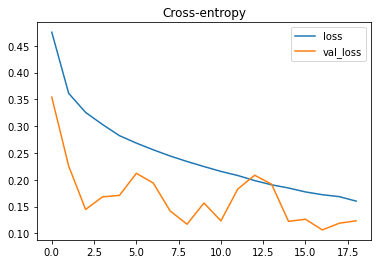

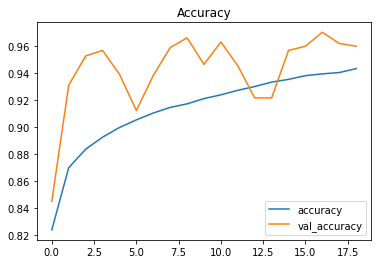

In [108]:
import pandas as pd

history_df = pd.DataFrame(history_vgg.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [17]:
model_vgg.load_weights('data/vgg19_model.h5')

In [18]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model_vgg.predict(test_generator)
print(predictions.shape)

predicted_classes = np.argmax(predictions, axis = 1)

2022-05-11 19:24:47.698016: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-11 19:24:47.833473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(968, 4)


In [19]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [20]:
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

         CNV       0.93      0.99      0.96       242
         DME       0.94      0.96      0.95       242
      DRUSEN       1.00      0.91      0.95       242
      NORMAL       0.98      0.97      0.98       242

    accuracy                           0.96       968
   macro avg       0.96      0.96      0.96       968
weighted avg       0.96      0.96      0.96       968



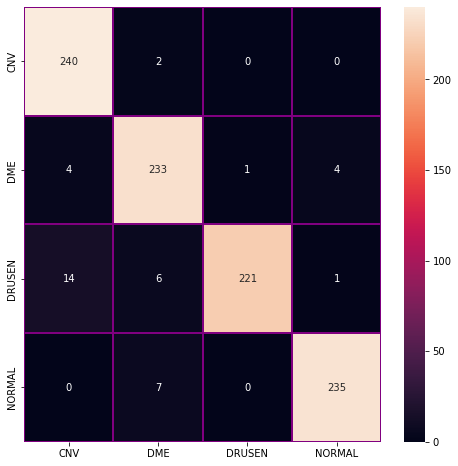

In [21]:
cm = sklearn.metrics.confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,8))
classes = train_generator.class_indices.keys()
sns.heatmap(cm, fmt='.0f', annot=True, linewidths=0.2, linecolor='purple', xticklabels=classes, yticklabels=classes)
plt.show()

In [65]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_vgg)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/gd/k530dpdn0b7bp0679ks43_th0000gn/T/tmpglsrriu0/assets


INFO:tensorflow:Assets written to: /var/folders/gd/k530dpdn0b7bp0679ks43_th0000gn/T/tmpglsrriu0/assets
2022-05-11 22:02:50.233790: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-11 22:02:50.233813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-11 22:02:50.233932: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/gd/k530dpdn0b7bp0679ks43_th0000gn/T/tmpglsrriu0
2022-05-11 22:02:50.236827: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-11 22:02:50.236841: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/gd/k530dpdn0b7bp0679ks43_th0000gn/T/tmpglsrriu0
2022-05-11 22:02:50.248177: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-11 22:02:50.381070: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

In [66]:
tflite_model_save_path = os.path.join('models/', "oct_converted_model.tflite")
with open(tflite_model_save_path, "wb") as f:
    f.write(tflite_model)

In [67]:
tflite_model_file = os.path.join('models/', 'oct_converted_model.tflite')
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

print(input_index)
print(output_index)

0
74


In [185]:
def run_tflite_model(tflite_file, test_image):

    interpreter = tf.lite.Interpreter(model_path='models/oct_converted_model.tflite')
    interpreter.allocate_tensors()
    print(interpreter.get_input_details())
    input_details = interpreter.get_input_details()[0]["index"]
    output_details = interpreter.get_output_details()[0]

    interpreter.set_tensor(input_details, test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    prediction = output.argmax()

    return prediction

In [186]:
import matplotlib.image as mpimg

converted_model = "models/oct_converted_model"
bad_image_path = "data/OCT2017 /val/DRUSEN/DRUSEN-9800172-2.jpeg"
image = tf.io.read_file(r"data/OCT2017 /val/DRUSEN/DRUSEN-9800172-2.jpeg")
image = tf.io.decode_image(image, dtype=tf.float32, channels=3)
print(image.shape)
converted = image[tf.newaxis, ...]
print(converted.shape)
resized = tf.image.resize(converted, [150, 150])
print(resized.shape)
prediction = run_tflite_model(converted_model, resized)
print(prediction)

(496, 512, 3)
(1, 496, 512, 3)
(1, 150, 150, 3)
[{'name': 'serving_default_vgg19_input:0', 'index': 0, 'shape': array([  1, 150, 150,   3], dtype=int32), 'shape_signature': array([ -1, 150, 150,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
2
